In [16]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import functools

NUM_ITER = 10000
LEARNING_RATE = .05

# CMPE482 Spring 2021 - Assignment 5
## Ege Can KAYA - 2018400018
### Question 1

We start by loading the Iris Dataset and putting it in the specified form.

In [17]:
iris = np.genfromtxt('iris.data', delimiter=',', dtype="|U15", encoding='utf-8', skip_header=50)

# setting the labels
iris = np.where(iris == 'Iris-versicolor', 0, iris)
iris = np.where(iris == 'Iris-virginica', 1, iris)

A = np.matrix(iris[:,:4], dtype='float')
y = np.matrix(iris[:, 4].reshape(100,1), dtype='int')

**a.** We simply carry out the specified computations and we plot the Iris-versicolor with the color red and the Iris-virginica with the color green:

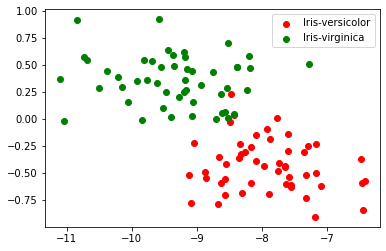

In [18]:
U, Sigma, Vt = np.linalg.svd(A)

# padding Sigma with zeros and diagonalizing
Sigma = np.pad(np.diag(Sigma), ((0,96), (0, 0)))

C = U.dot(Sigma)
X = C[:, :2]

# first 50 are versicolor and last 50 are virginica
plt.scatter([X[:50, 0]], [X[:50, 1]], color='r')
plt.scatter([X[50:, 0]], [X[50:, 1]], color='g')
plt.legend(['Iris-versicolor', 'Iris-virginica'])

**b.** An easy way to find a basis for any vector space is to follow the Gram-Schmidt process (do a QR-factorization), which gives us not just any basis, but an orthonormal basis. By QR-factorizing the $C$ and $X$ matrices, we see that:

In [19]:
Qx, R = np.linalg.qr(X)
Qc, R1 = np.linalg.qr(C)

print("Are Qx and the first two columns of Qc equal:", np.array_equal(Qx, Qc[:, :2]))

Are Qx and the first two columns of Qc equal: True


We observe that the obtained basis for $C$ is exactly the same as the first two columns of the obtained basis for $X$. Indeed, we are restricting our data to a plane, specifically, the plane which is spanned by the first two columns of the basis of $X$ obtained by a QR-factorization.

### Question 2

**a.** We first make the following derivation:

$$L(\theta)=\dfrac{1}{N}\sum_{i=1}^N -y_i \ln\left(\dfrac{1}{1+e^{-\theta^Tx}}\right) - (1-y_i) \ln\left(1 - \dfrac{1}{1+e^{-\theta^Tx}}\right) \\ $$

$$L(\theta_1, \theta_2) = \dfrac{1}{N} \sum_{i=1}^N -y_i \ln\left( \dfrac{1}{1+e^{-(\theta_1 x_{i_1}+\theta_2 x_{i_2})}}\right) - (1-y_i)\ln\left(1-\dfrac{1}{1+e^{-(\theta_1x_{i_1}+\theta_2x_{i_2})}}\right) \\ $$

And then, using Wolfram Alpha to take the partial derivative, we find:

$$\nabla_{\theta_i^{(k)}}L(\theta^{(k)}) = \dfrac{1}{N}\sum_{j=1}^N \dfrac{-y_j x_{j_i}e^{-\theta^{(k)^T}x_j}+x_{j_i}(-y_j+1)}{1+e^{-\theta^{(k)^T}x_j}} $$

**b.** We define our model, our loss function, and then use the facilities of JAX and the wonders of matrix multiplication to train our algorithm for 10000 iterations with a learning rate $\eta=.05$:

In [20]:
# initializing theta
np.random.seed(0)
theta_init = np.random.randn(2)/10
theta = theta_init.reshape(2, 1)

# define our logistic regression model
def model(theta, X):
    a = jnp.matmul(X, theta)
    return 1 / (1+jnp.exp(-a))

# define our logistic loss function
def loss(theta, y, X):
    N = y.shape[0]
    result = (-y*jnp.log(model(theta,X)) - (1 - y)*jnp.log(1 - model(theta, X))).sum()
    return result/N

# taking gradient is easy thanks to JAX!
dloss = jax.value_and_grad(loss)

# updating our theta with gradient descent mentality
def _update(theta, dtheta, learning_rate):
    return theta - learning_rate*dtheta

update = functools.partial(_update, learning_rate=LEARNING_RATE)

# train our model
for e in range(NUM_ITER):
    err, dtheta = dloss(theta, y, X)
    theta = jax.tree_multimap(update, theta, dtheta)

print('Model: logistic regression')
print('L and theta for iteration %i with learning_rate %f are:' % (NUM_ITER,LEARNING_RATE))
print(err, theta)

Model: logistic regression
L and theta for iteration 10000 with learning_rate 0.050000 are:
0.13006191 [[-0.04136017]
 [10.125258  ]]


**c.** We find our estimation for $\hat{y}$ using the $\theta^{(10000)}$ found by our algorithm, then label all values which are lower than $0.5$ as $0$ and all values that are higher than $0.5$ as $1$. We then calculate our accuracy as the ratio of correctly labeled observations to the number of all observations:

In [21]:
# estimate y with our fully trained theta
yhat_final = model(theta, X)
yhat_final = np.array(yhat_final)

# estimate the labels
yhat_final[yhat_final < .5] = 0
yhat_final[yhat_final > .5] = 1

# cast dtype to integer to allow comparison to the actual y
yhat_final = yhat_final.astype('int')

num_correct = np.sum(y == yhat_final)
print('Accuracy = ', num_correct/y.shape[0])

Accuracy =  0.96


**d.** Using `Code Snippet 2`, we get the following visualization for the decision boundary:

In [22]:
no_pts = 100
x_1 = np.linspace(-11.5, -5, no_pts)
x_2 = np.linspace(-1.5, 1.5, no_pts) 
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2) 
p_grid = np.zeros((no_pts, no_pts))
for i in range(no_pts):
    for j in range(no_pts):
        x_1 = x_1_grid[i, j]
        x_2 = x_2_grid[i, j]
        x = np.array([x_1, x_2])
        p_grid[i, j] = model(theta, x)

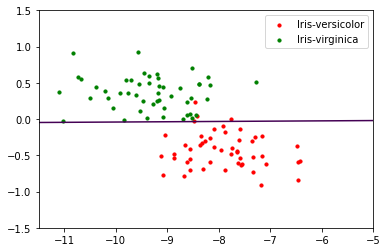

In [23]:
fig, ax = plt.subplots()
ax.scatter([X[:50, 0]], [X[:50, 1]], color='r', s=10)
ax.scatter([X[50:, 0]], [X[50:, 1]], color='g', s=10)
plt.legend(['Iris-versicolor', 'Iris-virginica'])
ax.contour(x_1_grid, x_2_grid, p_grid, levels=[.5]);

As can be seen, our model has correctly labeled $46$ of the red-colored points (those that fall below the line) and all $50$ of the green-colored points (since they all fall above the line). This results in $96$ correctly-labeled points out of $100$ in total, which explains the $.96$ accuracy.

### Question 3

**a.** By writing out the $W_1$ matrix and the $w_2$ and $x$ vectors and explicitly carrying out the multiplications, we get the following expression for $\hat{y}_i$:

$$\hat{y}_i  = \sigma \left[w_{2,1} \sigma(W_{1,1,1}x_{i_1}+\cdots+W_{1,1,d}x_{i_d})+\cdots+w_{2,p}\sigma(W_{1,p,1}x_{i_1}+\cdots+W_{1,p,d}x_{i_d})\right] $$

Now, it is clear to see that each entry of $W_1$ and $w_2$ affects one and only one term in the summation inside the outermost sigmoid function. Thus we can derive:

$$\nabla_{W_{1,i,j}^{(k)}}L(W_1^{(k)},w_2^{(k)}) =  \nabla_{W_{1,i,j}^{(k)}} \dfrac{1}{N} \sum_{l=1}^N -y_l \ln \left( \sigma \left[w_{2,i}^{(k)} \sigma \left( W_{1,i,j}^{(k)} x_{l_j} + c_{1_{i,j}}\right) + c_{2_{i,j}}\right]\right) - (1-y_l)\ln\left(1-\sigma \left[w_{2,i}^{(k)} \sigma \left( W_{1,i,j}^{(k)} x_{l_j} + c_{1_{i,j}}\right) + c_{2_{i,j}}\right]\right) \\ $$

where $c_{1_{i,j}}$ and $c_{2_{i,j}}$ are constants with respect to $W_{1,i,j}^{(k)}$ but that **do** depend on the indices $i$ and $j$. (These are the other summands inside the inner sigmoid function and the outer sigmoid function, respectively). Using Wolfram Alpha to carry out the differentiation, we get:

$$\nabla_{W_{1,i,j}^{(k)}}L(W_1^{(k)},w_2^{(k)}) = \dfrac{1}{N} \sum_{l=1}^N -\dfrac{w_{2,i}^{(k)}x_{l_j}e^{W_{1,i,j}^{(k)}x_{l_j}+c_{1_{i,j}}}\left((y_l-1)e^{\left(\frac{w_{2,i}^{(k)}}{e^{-\left(W_{1,i,j}^{(k)}x_{l_j}+c_{1_{i,j}}\right)}+1}\right)}+e^{c_{2_{i,j}}}y_l\right)}{\left(e^{W_{1,i,j}^{(k)}x_{l_j}+c_{1_{i,j}}}+1\right)^2\left(e^{\left(\frac{w_{2,i}^{(k)}}{e^{-\left(W_{1,i,j}^{(k)}x_{l_j}+c_{1_{i,j}}\right)}+1}\right)}+e^{c_{2_{i,j}}}\right)} \\ $$

Similarly, we find that 

$$\nabla_{w_{2,i}^{(k)}}L(W_1^{(k)},w_2^{(k)}) = \sum_{l=1}^N -\dfrac{e^{c_{1_{i,j}}+W_{1,i,j}^{(k)}x_{l_j}}\left((y_l-1)e^{\left(\frac{w_{2,i}^{(k)}}{e^{-\left(c_{1_{i,j}}+W_{1,i,j}^{(k)}x_{l_j}\right)}+1}\right)}+e^{c_{2_{i,j}}}y_l\right)}{\left(e^{c_{1_{i,j}}+W_{1,i,j}^{(k)}x_{l_j}}+1\right)\left(e^{\left(\frac{w_{2,i}^{(k)}}{e^{-\left(c_{1_{i,j}}+W_{1,i,j}^{(k)}x_{l_j}\right)}+1}\right)}\right)+e^{c_{2_{i,j}}}}$$

**b.** We initialize the given values and following the example of the second question, adapt our model to the MLP model:

In [24]:
# initializing our W_1 and w_2
W_1_init = np.random.randn(5, 2)/10 
w_2_init = np.random.randn(5)/10
W_1 = W_1_init
w_2 = w_2_init.reshape((5,1))

par = {"W_1": W_1, "w_2": w_2}

# define our multilayer perceptron model
def model_mlp(par, X):
    W_1 = par["W_1"]
    w_2 = par["w_2"]
    a = jnp.matmul(X, W_1.T)
    sig_1 = 1 / (1+jnp.exp(-a))
    b = jnp.matmul(sig_1, w_2)
    result = 1 / (1+jnp.exp(-b))
    return result

# define our logistic loss function (using the MLP model)
def loss_mlp(par, y, X):
    N = y.shape[0]
    result = (-y*jnp.log(model_mlp(par, X)) - (1 - y)*jnp.log(1 - model_mlp(par, X))).sum()
    return result/N

# get the gradient
dloss_mlp = jax.value_and_grad(loss_mlp)

# update parameters by gradient descent
def _update_mlp(par, dpar, learning_rate):
    return par - learning_rate*dpar

update_mlp = functools.partial(_update_mlp, learning_rate=LEARNING_RATE)

# train our model
for e in range(NUM_ITER):
    err, dpar = dloss_mlp(par, y, X)
    par = jax.tree_multimap(update_mlp, par, dpar)

print('Model: MLP')
print('L, W_1 and w_2 for iteration %i with learning_rate %f are:' % (NUM_ITER, LEARNING_RATE))
print(err, par["W_1"], par["w_2"])

Model: MLP
L, W_1 and w_2 for iteration 10000 with learning_rate 0.050000 are:
0.10685914 [[-0.07165473  2.8668852 ]
 [ 0.07988009 -4.3705554 ]
 [ 0.07333824 -3.3181498 ]
 [ 0.07369473 -1.6843278 ]
 [-0.07660748  3.904757  ]] [[ 2.762995 ]
 [-5.2576528]
 [-4.0280356]
 [-2.3067045]
 [ 3.9499612]]


**c.** Similarly to the second question, we estimate our labels with a decision threshhold of $.5$ and see that an accuracy level of $.97$ is attained. This is to say that our model has correctly labeled $97$ out of the total $100$ observations.

In [25]:
# Estimate y
yhat_mlp_final = model_mlp(par, X)
yhat_mlp_final = np.array(yhat_mlp_final)
# Estimate the labels
yhat_mlp_final[yhat_mlp_final < .5] = 0
yhat_mlp_final[yhat_mlp_final > .5] = 1


# Cast dtype to integer to allow comparison to the actual y
yhat_mlp_final = yhat_mlp_final.astype('int')


num_correct = np.sum(y == yhat_mlp_final)
print('Accuracy = ', num_correct/y.shape[0])

Accuracy =  0.97


**d.** Again using `Code Snippet 2`, we visualize our decision boundary:

In [26]:
no_pts = 100
x_1 = np.linspace(-11.5, -5, no_pts)
x_2 = np.linspace(-1.5, 1.5, no_pts) 
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2) 
p_grid = np.zeros((no_pts, no_pts))
for i in range(no_pts):
    for j in range(no_pts):
        x_1 = x_1_grid[i, j]
        x_2 = x_2_grid[i, j]
        x = np.array([x_1, x_2])
        p_grid[i, j] = model_mlp(par, x)

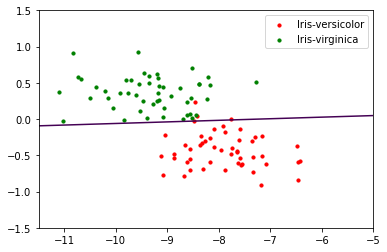

In [27]:
fig, ax = plt.subplots()
ax.scatter([X[:50, 0]], [X[:50, 1]], color='r', s=10)
ax.scatter([X[50:, 0]], [X[50:, 1]], color='g', s=10)
plt.legend(['Iris-versicolor', 'Iris-virginica'])
ax.contour(x_1_grid, x_2_grid, p_grid, levels=[.5]);

We see that the results are very similar with the logistic regression model. In fact, we can view logistic regression as a single-layer perceptron (or vice-versa, we can say that a multilayer perceptron is just multiple layers of logistic regression chained back to back), so this similarity is maybe not that surprising. With a large number of iterations such as $10000$, it is well expected that both systems give similar, equally good results. In addition, both the logistic regression model and the multilayer perceptron model are linear models, so their decision boundaries are expected to be lines in 2-dimensional space, which is what we observe here. It is also important to note that our data is **very close** to being linearly separable, so both methods give similar, very accurate results.

### Question 4
**a.** If we choose too small a value for $\eta$, it will take us many iterations to reach an optimum. On the other hand, if we choose too large a value, we might keep overshooting and maybe even end up with a configuration which never lets us get satisfactorily close to the optimum. I would say it is typical to try out a few values between $1$ and $10^{-6}$ and approach a good value by trial and error. It is a similar process for the selection of $K$ as well. Too small a $K$ may cause our algorithm to end before getting close enough to an optimum or too a large $K$ may cause many unnecessary operations that do not necessarily improve the result by much. In essence, my approach would be to train my model with some different values for $\eta$ and $K$ and use it on a validation set to get a sense for what works better.

**b.** A correct and smart way of doing this would be to train both models with an appropriately-sized training set (preferably larger than ours, a mere 100 observations), and then to test their performance on a validation set of **different** data to compare their respective accuracies. In fact, this is the essence of what we call generalization. It is generally not a smart idea to judge a model's accuracy by its performance on the data it was trained with, because of what we call **over-fitting**. A model which gets very well accustomed to its training data and gives amazing results may actually end up falling short of expectations when used on new data, which may be substantially different than the training data.

**c.** Choosing the number of layers in the MLP is also a similar issue. We can train MLPs with different numbers of layers and test their accuracy performance on a validation test to see how they generalize and then make a decision for how many layers to use. In the special case of our problem, where we have data which is almost linearly separable, having a single layer suits our needs and additional layers do not really add much value.